In [1]:
# import the libraries necessarry for cleaning and eda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='white')
plt.style.use('seaborn')

pd.set_option('display.max_columns', 100)  # display max rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # avoid outputing scientific notation

In [2]:
df = pd.read_csv('cardiac_train.csv')

In [3]:
print(df.shape)
df.head()

(50865, 13)


,age,gender,height,weight,bp_high,bp_low,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,56.86,female,1.68,72.00,120.00,80.00,well above normal,well above normal,0,0,1,0,25.51
1,41.89,male,1.80,80.00,110.00,70.00,normal,above normal,1,1,1,0,24.69
2,50.27,male,1.69,87.00,140.00,90.00,normal,normal,0,0,1,0,30.46
3,62.57,male,1.88,104.00,160.00,100.00,well above normal,well above normal,0,0,1,1,29.43
4,64.18,female,1.68,85.00,130.00,80.00,above normal,well above normal,0,0,1,1,30.12


## EDA
___

In [4]:
df.describe().iloc[[3,1,5,6,7],:]

,age,height,weight,bp_high,bp_low,smoke,alco,active,cardio,bmi
min,29.58,1.25,32.00,60.00,40.00,0.00,0.00,0.00,0.00,15.01
mean,53.24,1.65,71.65,126.18,81.18,0.09,0.05,0.80,0.48,26.36
50%,53.92,1.65,70.00,120.00,80.00,0.00,0.00,1.00,0.00,25.88
75%,58.34,1.70,79.00,140.00,90.00,0.00,0.00,1.00,1.00,29.02
max,64.93,2.07,125.00,240.00,180.00,1.00,1.00,1.00,1.00,35.00


In [5]:
df.corr().abs()['cardio']

age       0.24
height    0.00
weight    0.15
bp_high   0.43
bp_low    0.34
smoke     0.01
alco      0.01
active    0.03
cardio    1.00
bmi       0.17
Name: cardio, dtype: float64

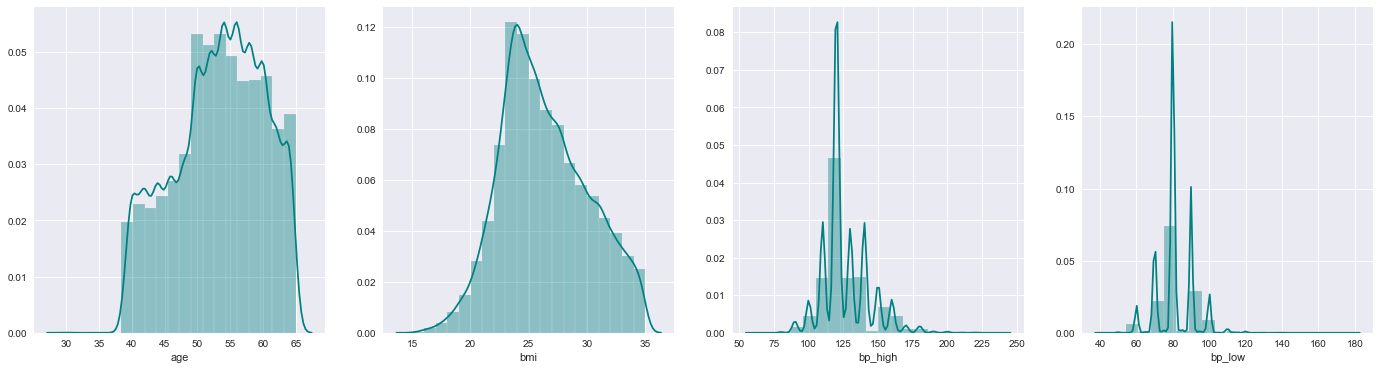

In [6]:
fig = plt.figure(figsize = (24,6))

num_cols = ['age','bmi','bp_high','bp_low',]

for n in range(0,4):
    ax = fig.add_subplot(1,4,n+1)
    sns.distplot(df[num_cols[n]], bins = 20, ax = ax, axlabel= num_cols[n],color='teal',)
plt.show()    

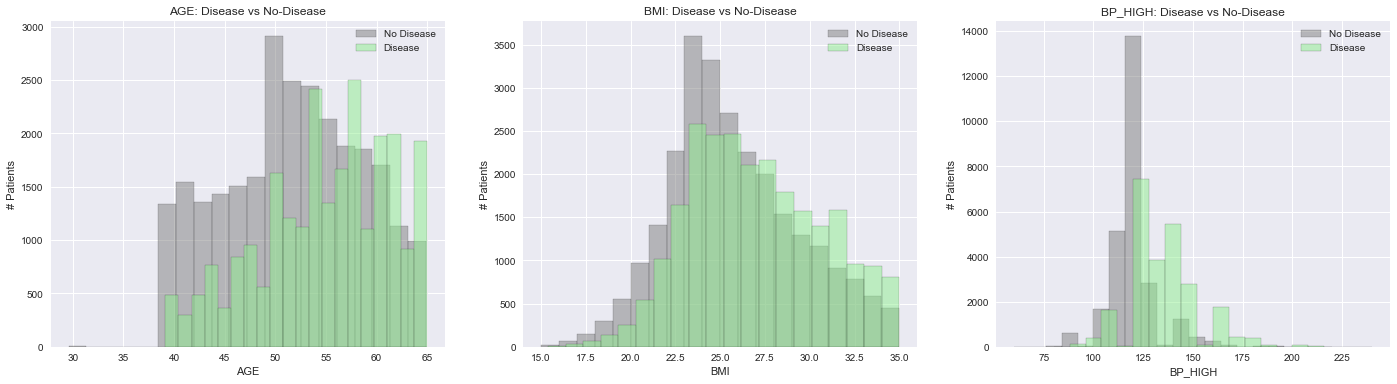

In [16]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (24,6))
fig.subplots_adjust(hspace = .30)

cols = ['age','bmi','bp_high']

for n in range(0,3):
    ax = fig.add_subplot(1,3,n+1)
    ax.hist(df[df['cardio'] ==0][cols[n]], bins = 20, label ='No Disease', alpha = .50,edgecolor= 'black',color ='grey')
    ax.hist(df[df['cardio']==1][cols[n]], bins = 20, label = 'Disease', alpha = .50, edgecolor = 'black',color = 'lightgreen')
    ax.set_title(cols[n].upper()+': Disease vs No-Disease')
    ax.set_xlabel(cols[n].upper())
    ax.set_ylabel('# Patients')
    ax.legend(loc = 'upper right')
plt.show()

In [17]:
df['bmi_cat'] = pd.cut(df['bmi'], right= False, bins = [0,18.5,25,30,36], 
                       labels=['underweight','normal','overweight','obese'])
df['bmi_cat'].value_counts(dropna = False)

normal         20448
overweight     20118
obese           9800
underweight      499
Name: bmi_cat, dtype: int64

In [45]:
dummy_df = pd.get_dummies(df, columns=['bmi_cat','gender'], prefix = '', prefix_sep = '', drop_first= True)

In [46]:
dummy_df = pd.get_dummies(dummy_df, columns=['cholesterol','gluc'], prefix =['chol','gluc'],)

In [61]:
dummy_df['bp_high'].corr(df['bp_low'])

0.7385562672368715

In [63]:
dummy_df['bp_lvl'] = dummy_df['bp_high'].apply(lambda x: 'crisis' if (x >= 180) else
                                              ('hyper_2' if (x < 180) & (x >= 140) else
                                              ('hyper_1' if (x < 140) & (x >= 130) else
                                              ('normal' if (x < 130) & (x >= 90) else 'low'))))

In [65]:
dummy_df = pd.get_dummies(dummy_df, columns=['bp_lvl'], prefix =['bp'],)

In [84]:
dummy_df.head()

,age,weight,bp_high,cardio,bmi,normal,obese,chol_above normal,chol_normal,chol_well above normal,gluc_normal,gluc_well above normal,bp_crisis,bp_hyper_1,bp_hyper_2,bp_normal
0,56.86,72.00,120.00,0,25.51,0,0,0,0,1,0,1,0,0,0,1
1,41.89,80.00,110.00,0,24.69,1,0,0,1,0,0,0,0,0,0,1
2,50.27,87.00,140.00,0,30.46,0,1,0,1,0,1,0,0,0,1,0
3,62.57,104.00,160.00,1,29.43,0,0,0,0,1,0,1,0,0,1,0
4,64.18,85.00,130.00,1,30.12,0,1,1,0,0,0,1,0,1,0,0


In [82]:
target_corr = dummy_df.corr().abs()['cardio']
drop_cols = list(target_corr[target_corr < 0.05].index)
print(drop_cols)

['height', 'smoke', 'alco', 'active', 'overweight', 'male', 'gluc_above normal', 'bp_low']


In [83]:
dummy_df.drop(columns=drop_cols, inplace=True)

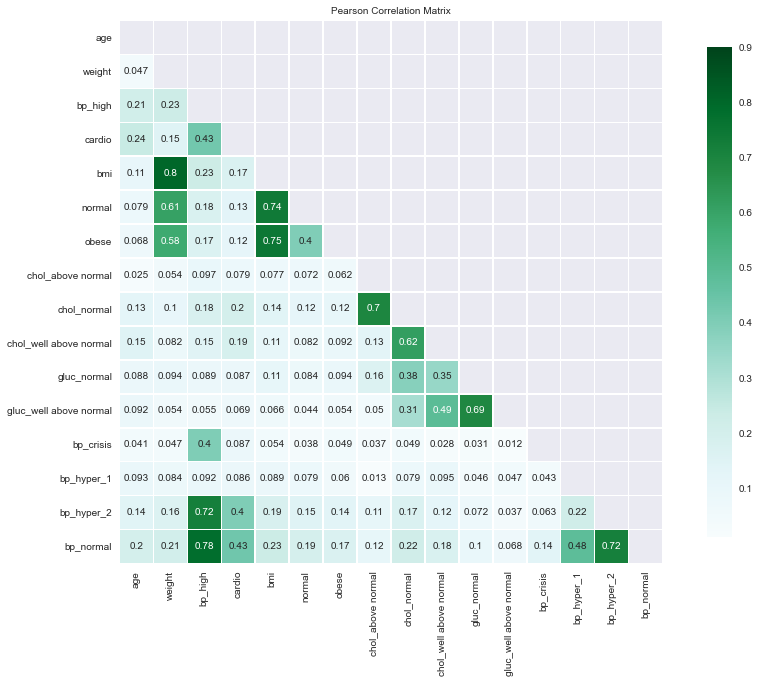

In [87]:
mask = np.zeros_like(dummy_df.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 10))
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(dummy_df.corr().abs(),linewidths=0.25,vmax=0.9,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":10},mask=mask,cbar_kws={"shrink": .9});
plt.show()

## 5. Model Fitting and Hyperparameter Tuning
___

In [93]:
from sklearn import metrics
from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score

In [89]:
# Split data to be used in the models
X = dummy_df.drop('cardio', axis = 1) # grabs everything else but 'catdio', creating a matrix of features

y = dummy_df['cardio'] # y is the column we're trying to predict 

In [94]:
y.value_counts(normalize=True)

0   0.52
1   0.48
Name: cardio, dtype: float64

In [128]:
X.shape

(50865, 15)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23, )

In [101]:
lr = LogisticRegression(penalty='l1', solver = 'liblinear', max_iter= 1000, verbose =1,)

lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print('accuracy score: ', accuracy_score(y_test, lr_pred))

[LibLinear]accuracy score:  0.7280805221357238


### Decision-Tree Classifier
___

In [102]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [103]:
decision_tree = DecisionTreeClassifier(random_state=1)

In [200]:
# creating our parameters to test
param_dict={'max_depth': [4], 'min_samples_leaf':[300], 'criterion': ['gini','entropy'],
           'max_features': [13]}

In [201]:
#create the instance of GridSearchCV using the F1 metric for our scoring. 
grid_tree= GridSearchCV(decision_tree, param_dict, cv=5, scoring='f1', verbose=1, n_jobs=-1)

In [202]:
#fit the Gridsearch to our data
grid_tree.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [4],
                         'max_features': [13], 'min_samples_leaf': [300]},
             scoring='f1', verbose=1)

In [203]:
print(grid_tree.best_score_)

# Dictionary containing the parameters used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)

0.7095013979216208
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 13, 'min_samples_leaf': 300}
DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=13,
                       min_samples_leaf=300, random_state=1)


In [204]:
train_pred = grid_tree.best_estimator_.predict(X_train)
y_pred = grid_tree.best_estimator_.predict(X_test)

print('Train F1: ', f1_score(y_train, train_pred ))
print("Test F1:", f1_score(y_test, y_pred), '\n')


print('Train accuracy: ', accuracy_score(y_train, train_pred ))
print("Test accuracy:", accuracy_score(y_test, y_pred))

Train F1:  0.713395207092395
Test F1: 0.7177097203728362 

Train accuracy:  0.7288193352207193
Test accuracy: 0.7332704254147991
